# Embedding Neural Data with UMAP
**Author:** Ethan Muchnik (emuchni2@uoregon.edu)

**Date:** 9/9/2023

**Summary:** We analyze a dataset containing simultaneous neural and vocal data from a singing zebra finch. The neural data was gathered using a Neuropixel and has been processed into a raster plot at 5ms resolution. The vocal data is a raw audio signal at 30 kHz. In this tutorial we review some audio processing, and then use dimensionality reduction to explore how the neural data is encoding song.  

Make a copy of this notebook in your drive, and make edits along the way!

## Required Libraries


In [1]:
pip install scipy numpy matplotlib umap-learn pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-any.whl size=86770 sha256=a969106777c51e5a89e573a21500756789e0531efabef67b735dabecdf7259b1
  Stored in directory: /root/.cache/pip/wheels/fb/66/29/199acf5784d0f7b8add6d466175ab45506c96e386ed5dd0633
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=3df10e25d4bc8b6d21e7c4c5bc62e8421f080ba1f3fc06d93e2dc9d8e07ce6da
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [2]:
# May take a minute
import numpy as np
import scipy
import matplotlib.pyplot as plt
import umap
import pandas as pd

## File Loading
To access the data choose one option:

1. Download the file and upload it to google colab via the folder menu.

2. Copy the file to your google drive, and mount google drive as I demonstrate.

In [3]:
# Connect this notebook to google drive (should pop up and request access)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load data from npz file
inputDataset = np.load('/content/drive/MyDrive/Pk146_Example_Neural_200Hz_Vocal_30kHz_20Bouts.npz',allow_pickle=True)

### This data contains four numpy arrays:

  - **Vocal_data**: A 1D array of length 20, where each element is an array containing raw microphone data from one bout of singing


  - **Neural_data**: Neural_Data[N] will access a raster plot of firing rate across 837 neurons at 5ms resolution for the neural data corresponding to the Nth bout of singing


  - **Vocal_time**: Single array which contains 30 kHz time points for the microphone data (all bouts are exactly the same length)


  - **Neural_time**: Single array which contains 200 Hz time points for neural data (all bouts are exactly the same length)

In [5]:
Vocal_data = inputDataset['vocal_data']
Neural_data = inputDataset['neural_data']
Vocal_time = inputDataset['vocal_time']
Neural_time = inputDataset['neural_time']

## Microphone Data

Let's explore what these bouts actually sound like!

In [6]:
# Play sound from an example bout
from IPython.display import Audio

example_bout = 6
bout_audio = Vocal_data[example_bout - 1] # Remember python indexing starts at zero!
Audio(bout_audio, rate=30000) # this whole dateset 30kHz

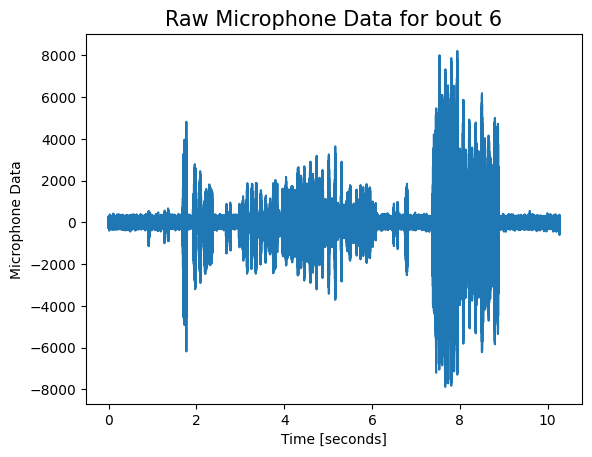

In [7]:
# We can plot this microphone data
plt.plot(Vocal_time,bout_audio)
plt.title(f'Raw Microphone Data for bout {example_bout}',fontsize = 15)
plt.xlabel('Time [seconds]',fontsize = 10)
plt.ylabel('Microphone Data',fontsize = 10)
plt.show()

In [8]:
# A spectrogram is a more interpretable way to plot audio

# Parameters for https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html
FS = 30000
NFFT = 512
noverlap = 450
logAdditive = 2

f, tSpec, Sxx = scipy.signal.spectrogram(bout_audio, FS,nfft = NFFT,noverlap = noverlap,nperseg = NFFT)
logSpec = np.log(Sxx + logAdditive)



Try some variations on this spectrogram code:
  - How would you increase time resolution?
  - Can you add another processing step where you set any elements in logSpec below a threshold to zero
  - You can also display logSpec with plt.imshow instead of plt.pcolormesh

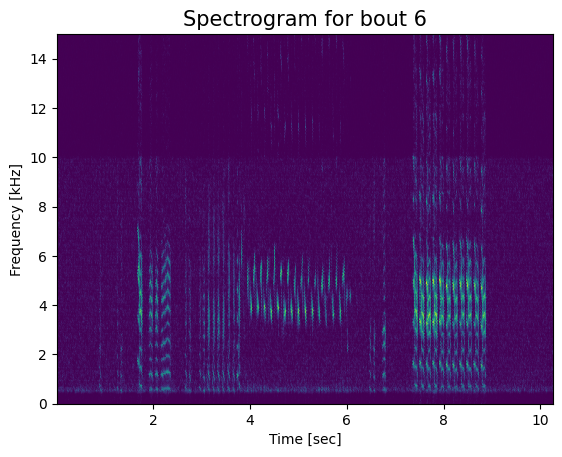

In [9]:
# Displaying the spectrogram
plt.pcolormesh(tSpec, f/1000, logSpec, shading='gouraud')
plt.ylabel('Frequency [kHz]',fontsize = 10)
plt.xlabel('Time [sec]',fontsize = 10)
plt.title(f'Spectrogram for bout {example_bout}',fontsize = 15)
plt.show()


## Spiking Data

In [10]:
Neural_data.shape # 20 bouts, 837 neurons, 2051 time bins

(20, 837, 2051)

In [11]:
# Let's use the same example bout and grab the spiking data
exampleSpkData = Neural_data[example_bout - 1]

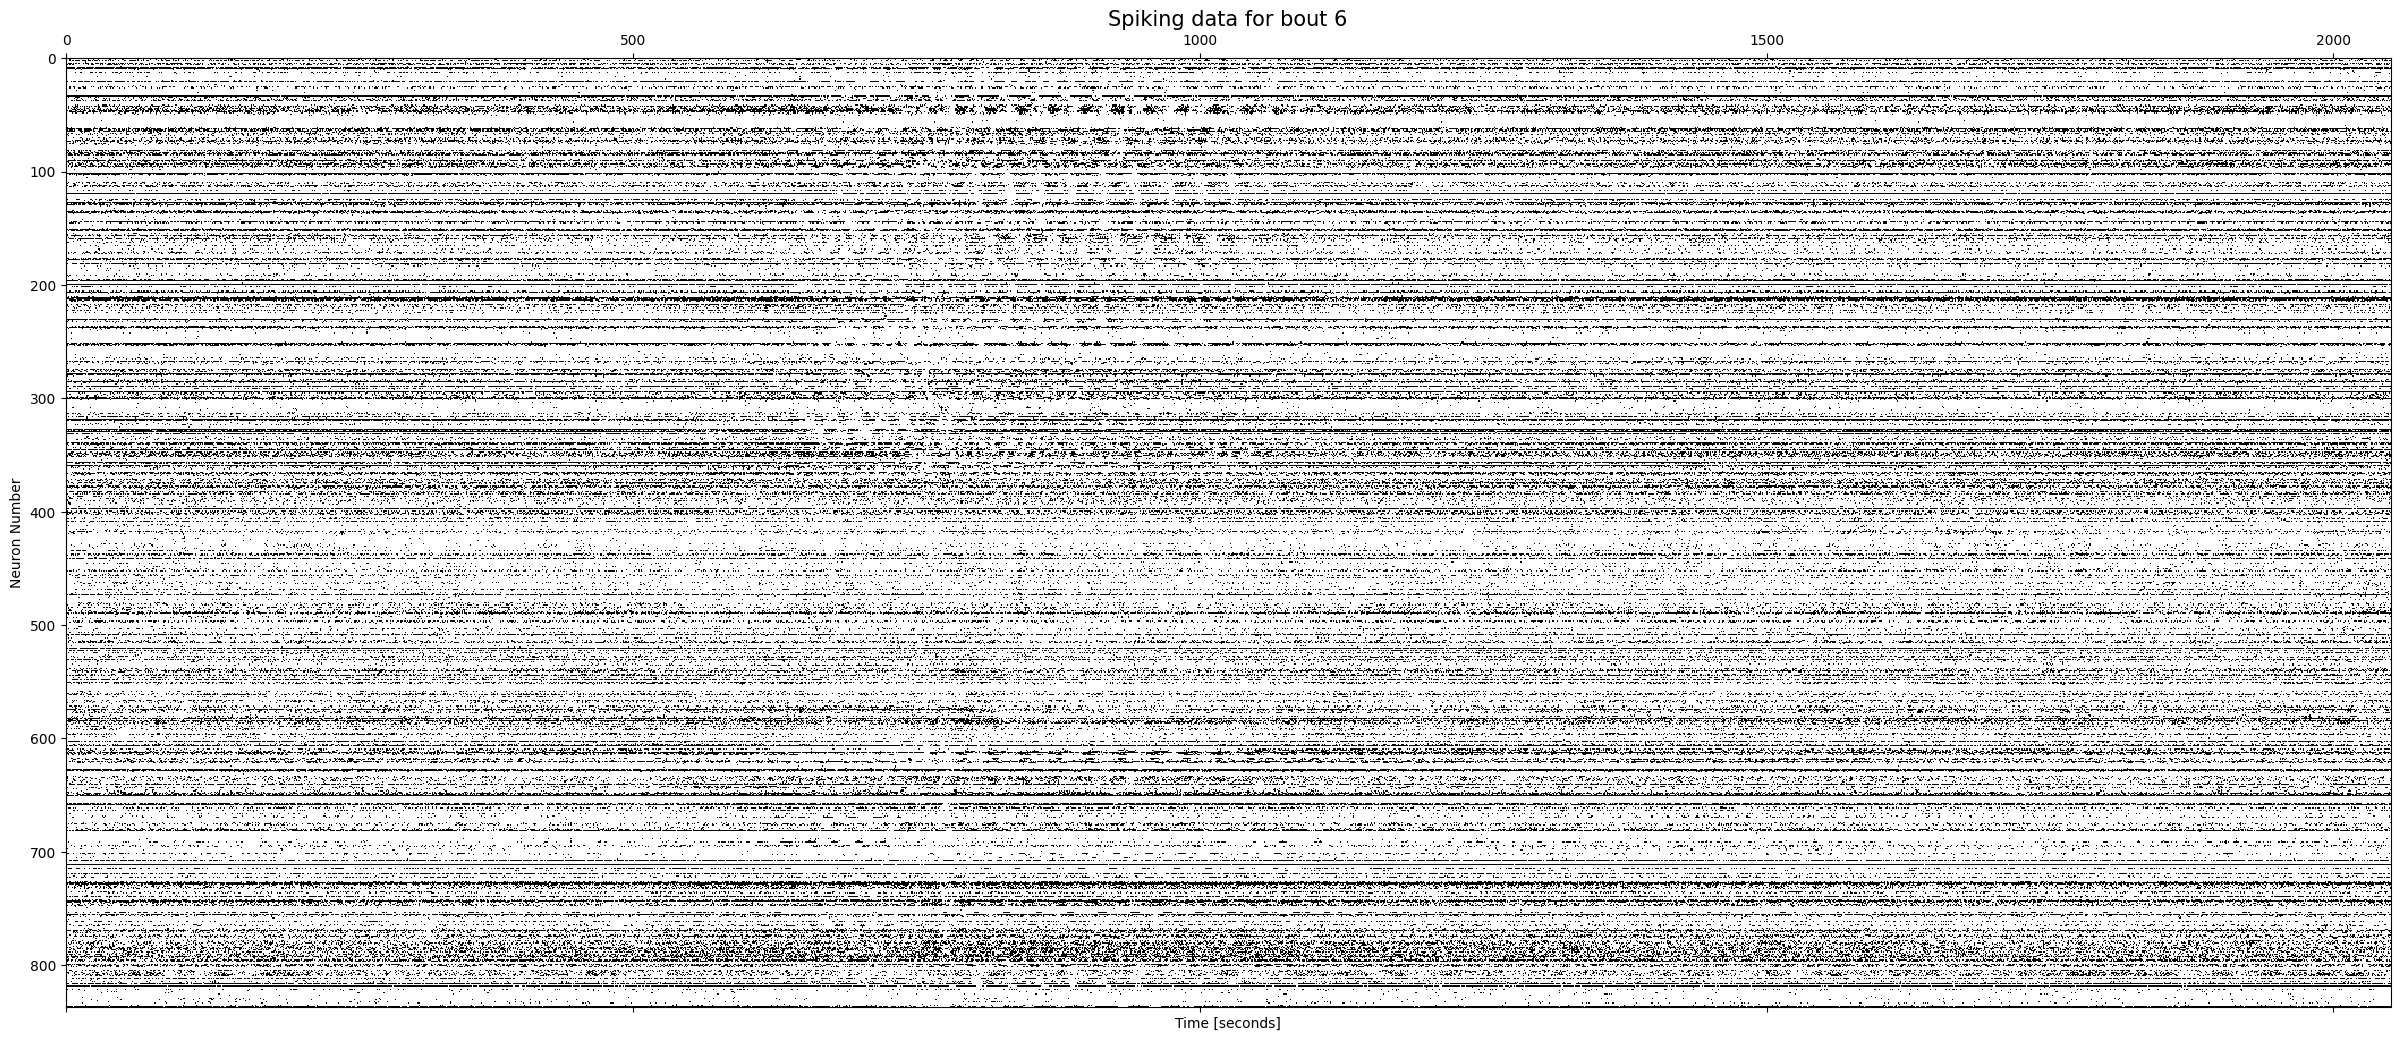

In [38]:
# Let's plot this using plt.spy (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.spy.html)
plt.figure(figsize = (30,20))
extentInput = [Neural_time[0],Neural_time[-1],0,exampleSpkData.shape[0]] # Need to tell the plot our xmin,xmax,ymin,ymax for the image data
plt.spy(exampleSpkData)
plt.title(f'Spiking data for bout {example_bout}',fontsize = 15)
plt.xlabel('Time [seconds]',fontsize = 10)
plt.ylabel('Neuron Number',fontsize = 10)
plt.show()

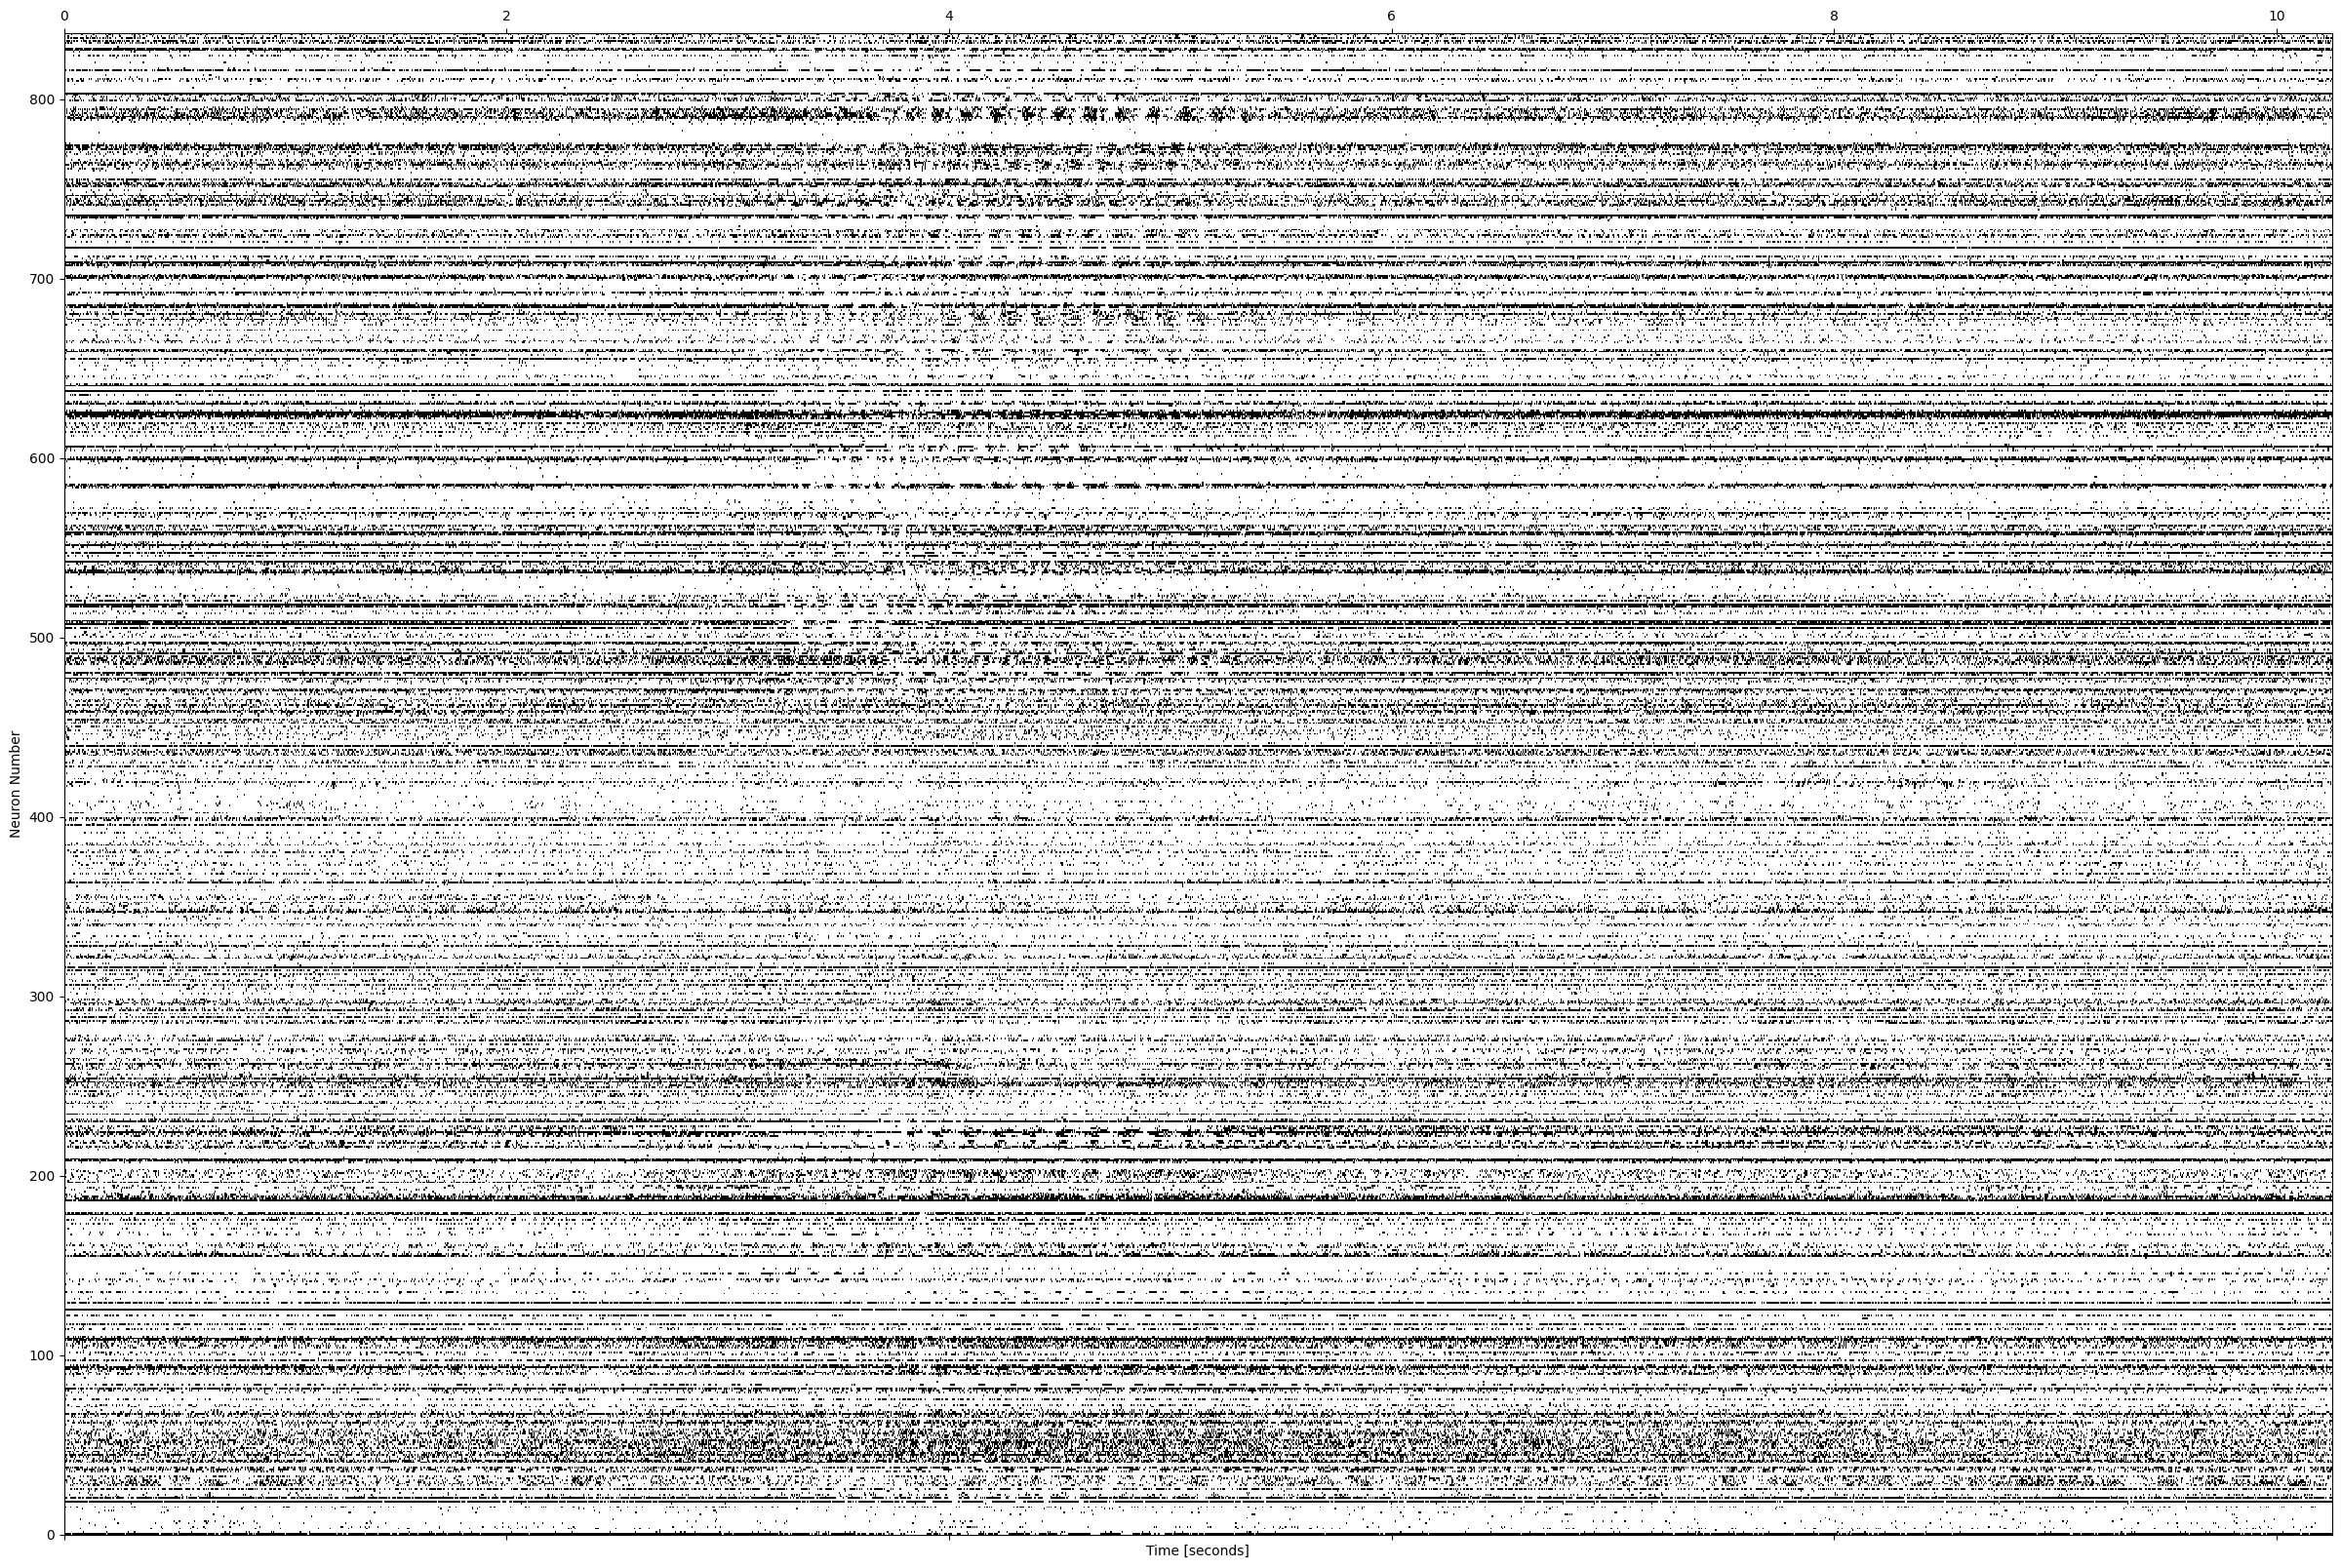

In [13]:
aveSpike = np.mean(Neural_data[0:20],axis = 0)
plt.figure(figsize = (30,20))
extentInput = [Neural_time[0],Neural_time[-1],0,exampleSpkData.shape[0]] # Need to tell the plot our xmin,xmax,ymin,ymax for the image data
plt.spy(aveSpike, extent = extentInput, aspect = 'auto')
# plt.title(f'Spiking data for bout {example_bout}',fontsize = 15)
plt.xlabel('Time [seconds]',fontsize = 10)
plt.ylabel('Neuron Number',fontsize = 10)
plt.show()

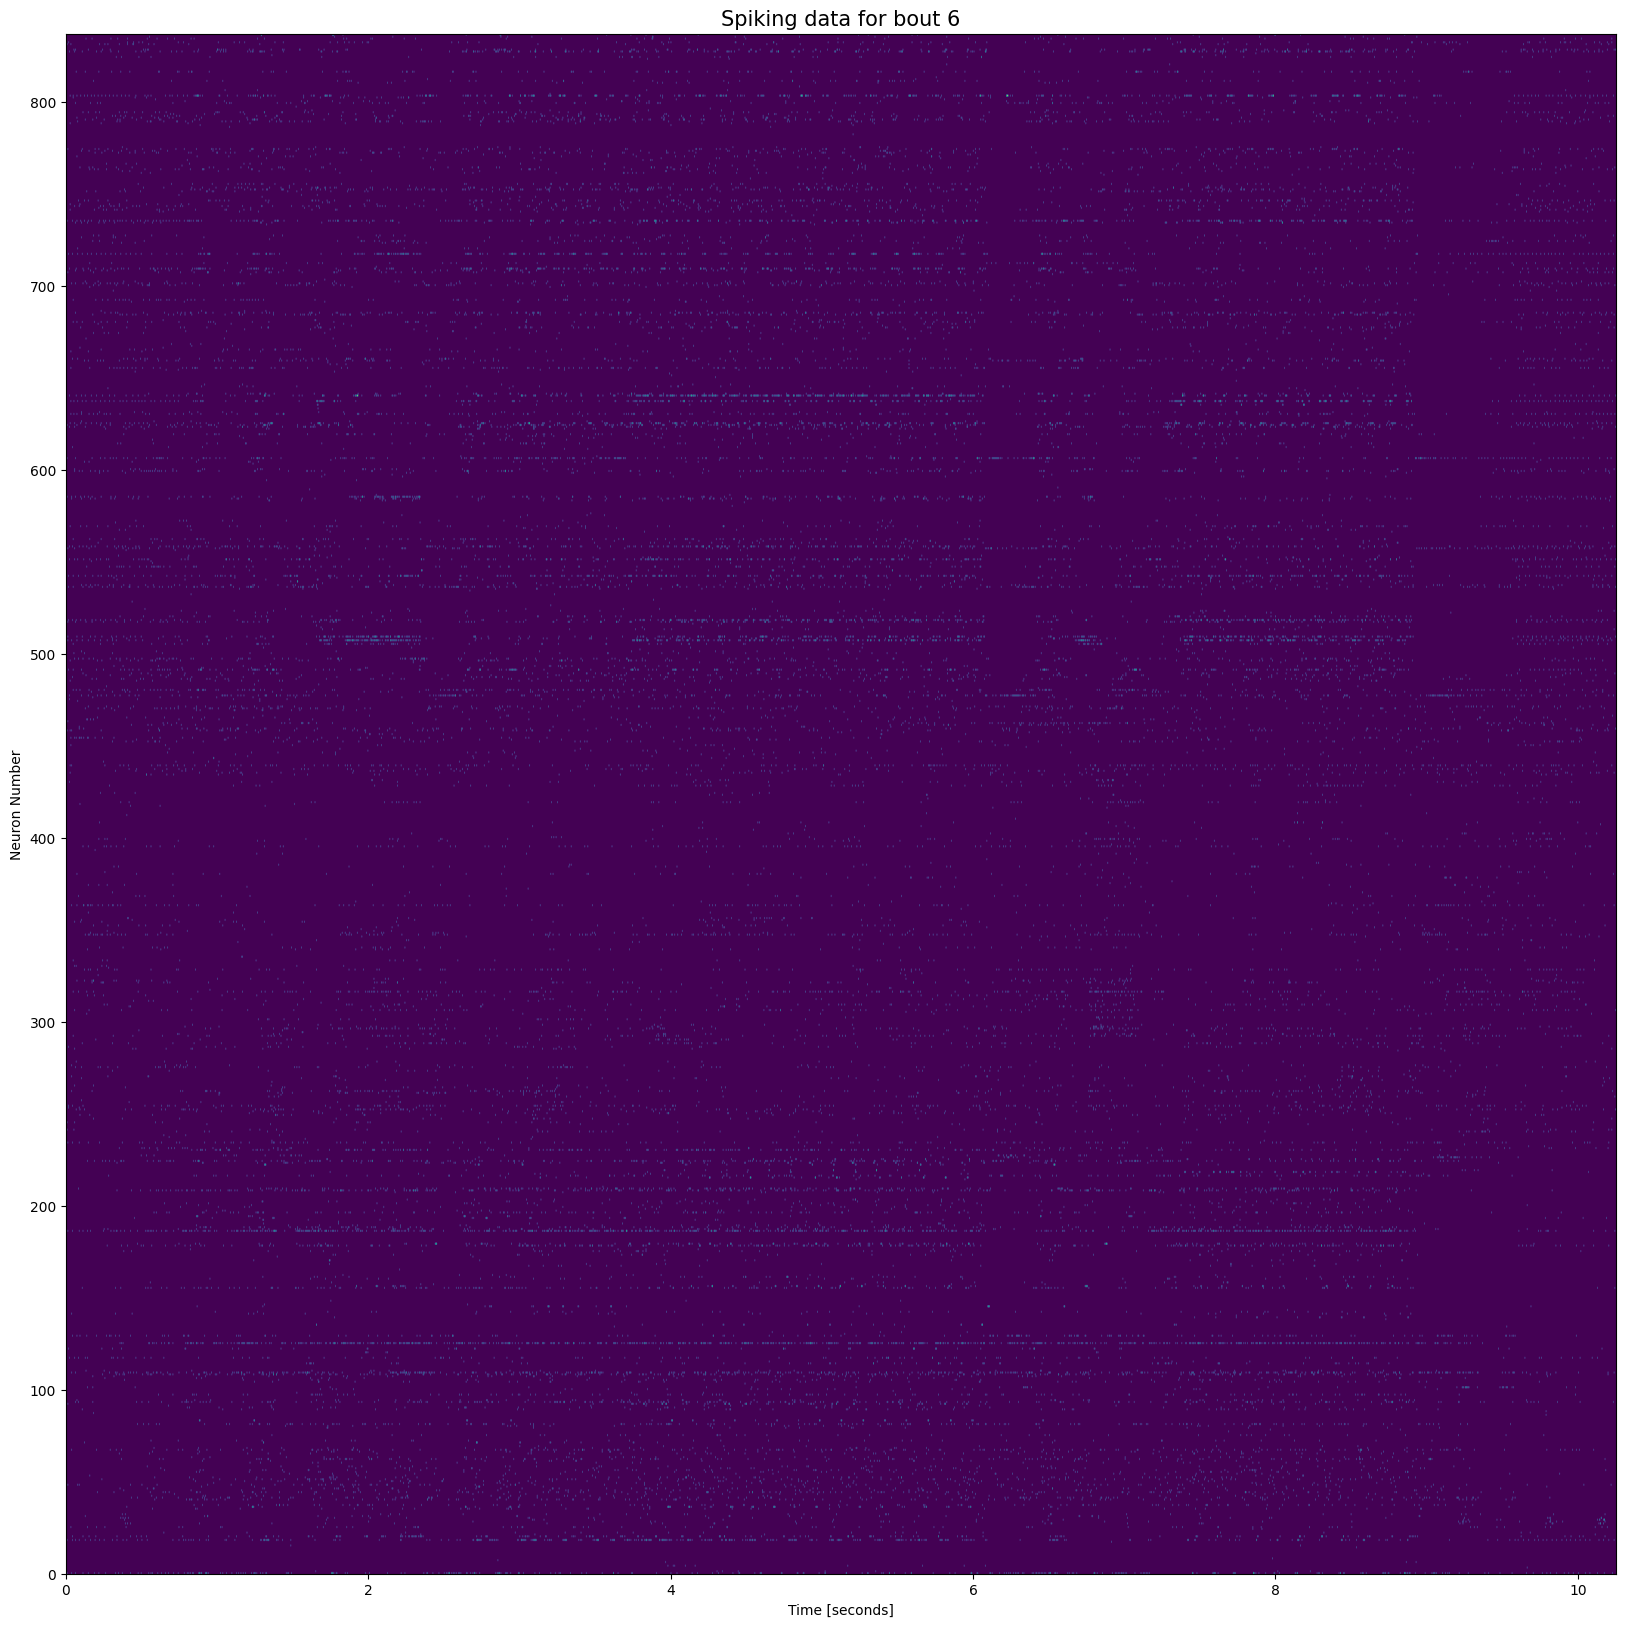

In [14]:
# You can also plot it with imshow but some of the spikes get drowned out by a background
plt.figure(figsize = (20,20))
plt.imshow(exampleSpkData,aspect = 'auto',extent = extentInput)
plt.title(f'Spiking data for bout {example_bout}',fontsize = 15)
plt.xlabel('Time [seconds]',fontsize = 10)
plt.ylabel('Neuron Number',fontsize = 10)
plt.show()

Try plotting a subset of the data in time or neuron to see finer detail

## UMAP

Uniform Manifold Approximation and Projection (UMAP) is a dimensionality reduction algorithm that leverages topological analysis to embed data sets in lower dimen-sions while preserving global structure. The foundational math behind UMAP involves representing each data point on a high dimensional manifold and creating “fuzzy” con-nections between neighbors via a distance metric

### Methodology

To represent the neural data in a lower dimensional space we will:

1. Smooth the data via a gaussian blurring to allow overlap in spike times near but not exactly aligned
2. Slice the data into segments
3. Perform UMAP to create a 2D or 3D representation of these slices

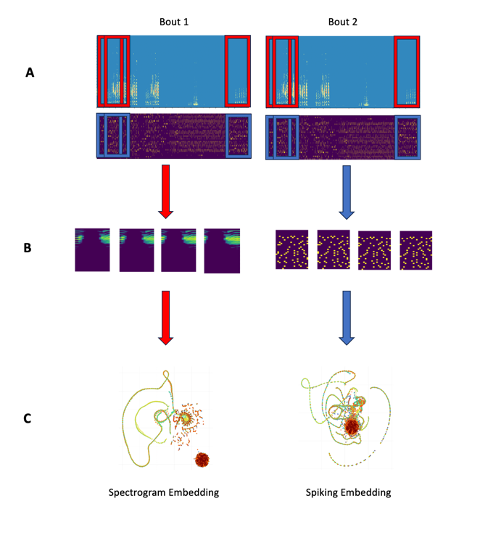

First we smooth each row of the data with a gaussian filter

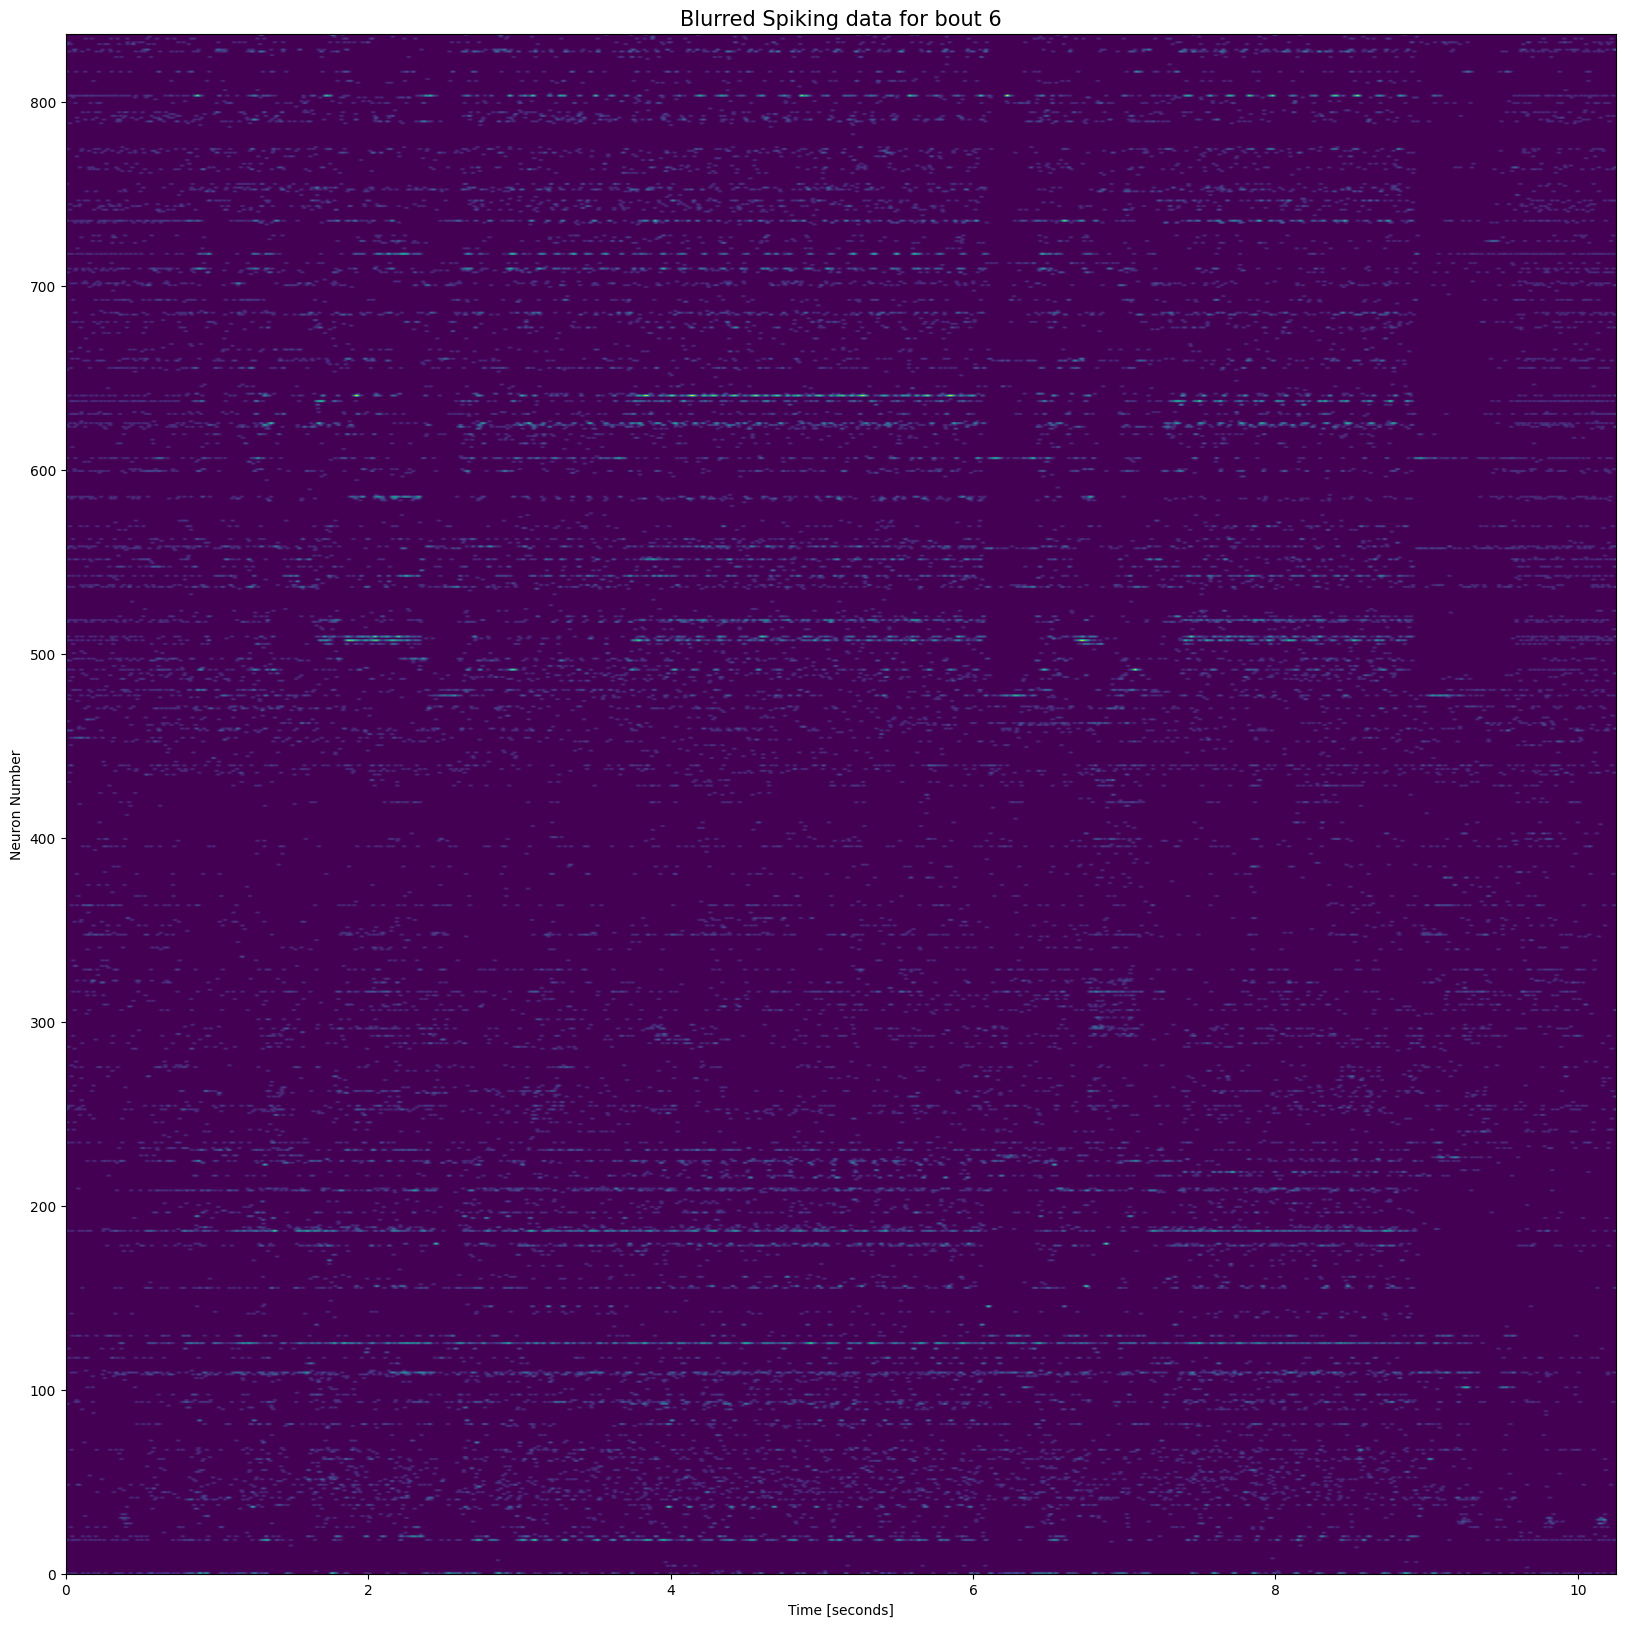

In [15]:
# Smooth data with gaussian kernel

def apply_gaussian_kernel(data, time_const = 10):

    result = np.zeros_like(data)
    for i in range(data.shape[0]):
        result[i] = scipy.ndimage.gaussian_filter1d(data[i], time_const)

    return result

smoothed_spiking = apply_gaussian_kernel(exampleSpkData,time_const = 2) # blur array
plt.figure(figsize = (20,20))
plt.imshow(smoothed_spiking,aspect = 'auto',extent = extentInput)
plt.title(f'Blurred Spiking data for bout {example_bout}',fontsize = 15)
plt.xlabel('Time [seconds]',fontsize = 10)
plt.ylabel('Neuron Number',fontsize = 10)
plt.show()

Now we slice the data (play with the window and step size for varied results)

In [16]:
# To do umap we are going to take slices of this data

def get_matrix_slices(matrix, window_size, step_size):
    matrix_shape = matrix.shape
    num_slices = (matrix_shape[1] - window_size) // step_size + 1
    slices = np.zeros((matrix_shape[0], window_size, num_slices))
    slice_times = np.zeros((num_slices))

    for i in range(num_slices):
        start = i * step_size
        end = start + window_size
        slices[:, :, i] = matrix[:, start:end]
        slice_times[i] = (start + end)/2

    return slices,slice_times

window_size = 20 # should adjust with binning (5ms --> 20 100ms)
step_size = 2
slices, slice_times = get_matrix_slices(smoothed_spiking,window_size, step_size)

In [17]:
print(slices.shape) # (Num Neuron, Window Size pixels, Num slices)

(837, 20, 1016)


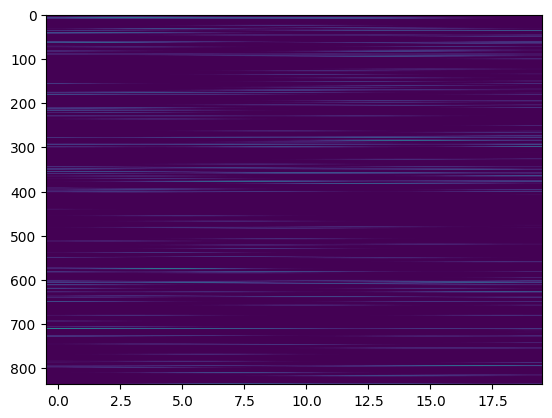

In [18]:
# Let's plot one slice (one moment in song!)

plt.imshow(slices[:,:,99],aspect = 'auto') # NOTE the x axis is 20 bins (not time, the aspect ratio has changed)
plt.show()

UMAP requires a specific input format where the array is 2d with (numInputs, inputSize) as the dimensions. This is just some numpy algebra!

In [19]:
# Some algebra to prepare for umap

# Turn each slice into a 1D vector
original_shape = slices.shape
flattened_matrix = slices.reshape(original_shape[0] * original_shape[1], original_shape[2]).T

# calculate start times in seconds CHNAGE
roundingFactor = 150
relTime = slice_times*roundingFactor/FS

In [20]:
# Load the umap library, and transform the data
fit = umap.UMAP() # Read this and change the input options (metric, n neighbors, etc): https://umap-learn.readthedocs.io/en/latest/parameters.html
spk_emb = fit.fit_transform(flattened_matrix)

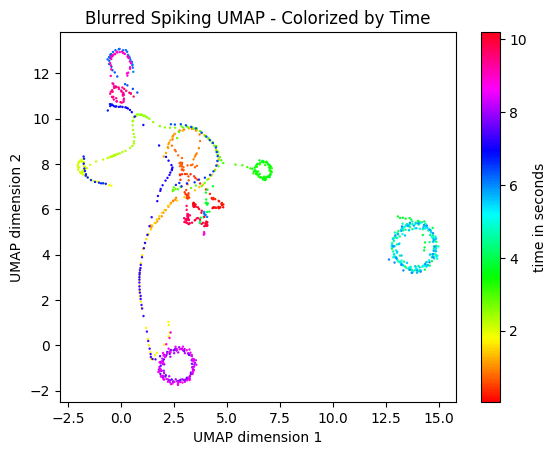

In [24]:
# Plot data in UMAP space
plt.scatter(spk_emb[:,0],spk_emb[:,1],s = .5,c = relTime,cmap='hsv')
plt.title('Blurred Spiking UMAP - Colorized by Time')
plt.xlabel('UMAP dimension 1')
plt.ylabel('UMAP dimension 2')
cbar = plt.colorbar()
cbar.set_label('Time in seconds')
plt.show()

## Visualization Methods!

Let's reduce to 3D instead of 2D and use these triplets to generate RGB colors and plot these colors under the spectrogram. That way we can represent the brain state as a color during each moment of song

In [ ]:
# Load the umap library, and transform the data
fit = umap.UMAP(n_components = 3)
spk_emb_3D = fit.fit_transform(flattened_matrix)

In [ ]:
# Rescaling function to take any range of 3d data and make a 0-1 triplet for RGB
def min_max_scale(matrix):
    min_vals = np.min(matrix, axis=0)
    max_vals = np.max(matrix, axis=0)

    # Perform min-max scaling for each column
    scaled_matrix = (matrix - min_vals) / (max_vals - min_vals)

    return scaled_matrix

In [ ]:
# Scale and interpolate the data to match the number of columns in our spectrogram
color_emb = min_max_scale(spk_emb_3D).T
interpolated_colors = np.zeros((color_emb.shape[0], len(tSpec)))

for i in range(color_emb.shape[0]):
    interpolated_colors[i] = np.interp(tSpec, relTime, color_emb[i])


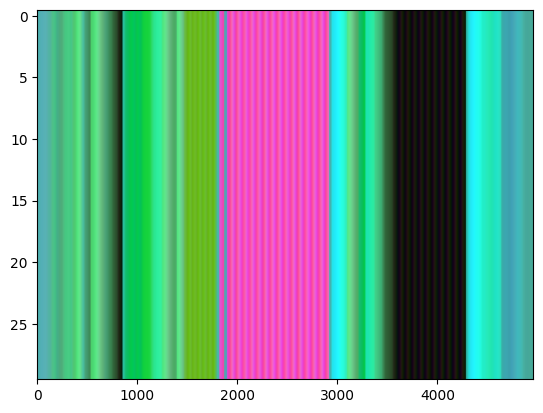

In [ ]:
# Turn our color array into an image with columns representing the neural state
dispImg = np.zeros((30,interpolated_colors.shape[1],3))

for column in range(dispImg.shape[1]):
  dispImg[:,column,:] = interpolated_colors[:,column]

plt.imshow(dispImg,aspect = 'auto')
plt.show()

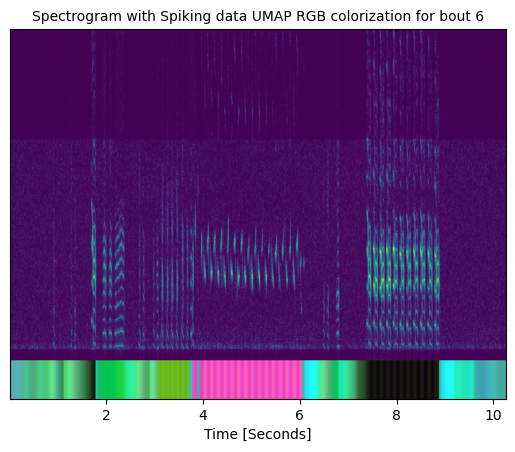

In [ ]:
# Turn the spectrogram and neural state into one RGB image

# plt.figure(figsize = (20,20))
colormap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=np.min(logSpec), vmax=np.max(logSpec))

# Apply the colormap to the normalized data to get RGB values
rgb_array_spec = colormap(norm(logSpec))[:, :, :3]

stackedImage = np.vstack((dispImg,rgb_array_spec))
plt.imshow(stackedImage,aspect= 'auto',origin = 'lower',extent = [tSpec[0],tSpec[-1],0,stackedImage.shape[0]])
plt.xlabel('Time [Seconds]',fontsize = 10)
plt.title(f'Spectrogram with Spiking data UMAP RGB colorization for bout {example_bout}',fontsize = 10)
ax = plt.gca()
ax.get_yaxis().set_visible(False)


Want to modify the code? Try:

- Embedding the spectrograms using UMAP
- Changing UMAP parameters
- Combining data from all 20 bouts then running UMAP
- Thinking of better ways to visualize the data